In [0]:
import cv2
import sys
import math
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

#plt.rcParams['figure.figsize'] = (15, 10)
plt.rcParams['axes.grid'] = False

In [0]:
def isValid(x, y, r, c):
    if(x>=0 and x<r and y>=0 and y<c):
        return 1
    else:
        return 0

(Q2) Implement adaptive thresholding algorithm (‘threshold.jpg’) and get the outcome for the threshold at each iteration. Use 5x5, 7x7, 9x9 patch sizes to get 3 different segmentation outcomes. And find out which local patch size gives the best result for the input image.

Hint: you may use the global thresholding concept to compute the optimal threshold in each patch.

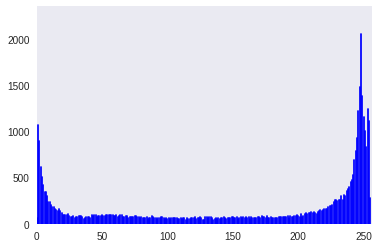

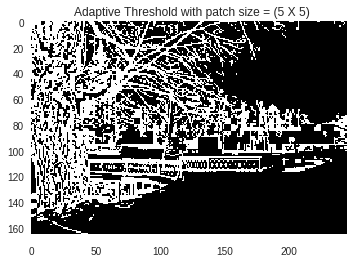

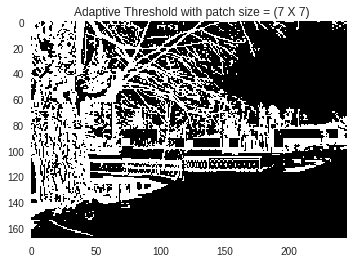

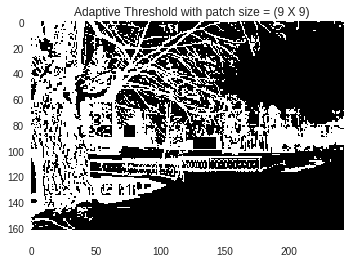

In [0]:
def global_thresholding(img, r, c, t):
    #two matrices for two segments of image (one with pixels value>t and other with <t)
    g1 = np.zeros((r,c), np.uint8)
    g2 = np.zeros_like(g1)
    
    #print(img.shape)
    
    count1=0
    count2=0
    mu1=0
    mu2=0

    for i in range(r):
        for j in range(c):
            if(img[i][j] >= t):
                g1[i][j] = img[i][j]
                count1 += 1
                mu1 += g1[i][j]
            
            else:
                g2[i][j] = img[i][j]
                count2 += 1
                mu2 += g2[i][j]
    
    if(count1 != 0):
        mu1 /= count1
    
    if(count2 != 0):
        mu2 /= count2

    tnew = (mu1 + mu2)/2
    return math.floor(tnew + 0.5)


def adaptive_thresholding(img, patch_size):
    t = 200
    t0 = 0
    
    r, c = img.shape
    thresh_img = np.zeros(img.shape)
    
    for i in range(0, r-patch_size, patch_size):
        for j in range(0, c-patch_size, patch_size):
            
            t = 200
            t0 = 0
    
            #print("Initial Threshold = 200")
            #show_thresh_image(img, t, "Initial Threshold = 200")

            iteration = 1
            img_patch = img[i:i+patch_size, j:j+patch_size]
    
            while(1):
                tnew = global_thresholding(img_patch, patch_size, patch_size, t)
                if(abs(t-tnew) <= t0):
                        break
                t = tnew
                iteration += 1
            
            for p in range(i, i+patch_size):
                for q in range(j, j+patch_size):
                    if(img[p][q] > t):
                        thresh_img[p][q] = 255
    
            #print("Thresholding stopped after", iteration, "iterations")
            #print("Final Threshold = ", t)
    
    plt.title("Adaptive Threshold with patch size = ({0} X {0})". format(patch_size))
    plt.imshow(thresh_img)
    plt.show()
    

def show_thresh_image(img, t, title):
    img2 = np.zeros_like(img)
    img2[img>t] = 255
    
    plt.title(title)
    plt.imshow(img2)
    return


img = cv2.imread('threshold.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

r, c = img.shape

hist = []

for i in range(256):
    hist.append(0)

for i in range(len(img)):
    for j in range(len(img[i])):
        hist[img[i][j]] += 1

plt.axis([0, 256, 0, max(hist)+300])        
for i in range(256):
    plt.plot([i,i], [0, hist[i]], color = "blue")

plt.show()

adaptive_thresholding(img, 5)
adaptive_thresholding(img, 7)
adaptive_thresholding(img, 9)

(Q3) Implement canny edge detector and get the segmentation output for image ‘background.jpg’. Also, after getting the binary image, perform edge linking to join the disconnected edge pixels by implementing the local edge linking technique as discussed in the class.

Sigma = 1.4
Low threshold = 20
High threshold = 45


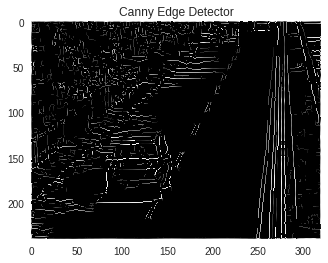

In [0]:
sys.setrecursionlimit(1000*1000*4)

def apply_filter(kernel, r, c, img):
    value = 0
    k_r, k_c = len(kernel), len(kernel[0])
    i_r, i_c = img.shape
    
    for i in range(k_r):
        for j in range(k_c):
            x = i + r - (k_r//2)
            y = j + c - (k_c//2)

            if(isValid(x, y, i_r, i_c)):
                value += (kernel[i][j] * img[x][y])
    return value


def dfs_visit(suppressed, r, c, visited, i, j):
    if(visited[i][j] == 1):
        return

    if(suppressed[i][j] < th_low):
        visited[i][j] = 1
        return
    
    visited[i][j] = 1

    for p, q in [(i-1, j-1), (i-1, j), (i-1, j+1), (i, j-1), (i, j+1), (i+1, j-1), (i+1, j), (i+1, j+1)]: 
        if(isValid(p, q, r, c)):
            dfs_visit(suppressed, r, c, visited, p, q)
        
    return


sigma = 1.4
img = cv2.imread('background.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

#im = gaussian_blur(im, sigma)
img = cv2.GaussianBlur(img, (5, 5), 1.4)

#sobel filters for gradients in x and y directions
filter_x = [[-1,0,1], [-2,0,2], [-1,0,1]]
filter_y = [[-1,-2,-1], [0,0,0], [1,2,1]]

r, c = img.shape

grad_x = np.zeros(img.shape, np.float)
grad_y = np.zeros(img.shape, np.float)

grad_magnitude = np.zeros(img.shape, np.float)
grad_angle = np.zeros(img.shape, np.float)

for i in range(r):
    for j in range(c):
        grad_x[i][j] = apply_filter(filter_x, i, j, img)
        grad_y[i][j] = apply_filter(filter_y, i, j, img)
        
        x, y = grad_x[i][j], grad_y[i][j]
        
        grad_magnitude[i][j] = math.sqrt((x ** 2) + (y ** 2))
        
        t = round(math.degrees(math.atan2(y,x)), 3)
        if(t < 0):
            t += 180
        
        grad_angle[i][j] = t
        

suppressed = np.copy(grad_magnitude)
th_low= 20
th_high= 45

for i in range(r):
    for j in range(c):
        angle = grad_angle[i][j]
        pixel1 = 0
        pixel2 = 0

        if((angle>=0 and angle<=22.5) or (angle>157.5 and angle<=180)):
            if(j-1>=0):
                pixel1 = grad_magnitude[i][j-1]
            if(j+1<c):
                pixel2 = grad_magnitude[i][j+1]
        
        elif(angle>22.5 and angle<=67.5):
            if(j-1>=0 and i+1<r):
                pixel1 = grad_magnitude[i+1][j-1]
            if(j+1<c and i-1>=0):
                pixel2 = grad_magnitude[i-1][j+1]
        
        elif(angle>67.5 and angle<=112.5):
            if(i-1>=0):
                pixel1 = grad_magnitude[i-1][j]
            if(i+1<r):
                pixel2 = grad_magnitude[i+1][j]
        
        elif(angle>112.5 and angle<=157.5):
            if(i-1>=0 and j-1>=0):
                pixel1 = grad_magnitude[i-1][j-1]
            if(i+1<r and j+1<c):
                pixel2 = grad_magnitude[i+1][j+1]
        
        if(grad_magnitude[i][j] < pixel1 or grad_magnitude[i][j] < pixel2):
            suppressed[i][j] = 0

plt.imshow(suppressed.astype(np.uint8), cmap = "gray")

visited = np.zeros_like(suppressed)
for i in range(r):
    for j in range(c):
        if(suppressed[i][j] > th_high and visited[i][j] == 0):
            dfs_visit(suppressed, r, c, visited, i, j)
            
#pixels which have not been visited represent weak edges , so set them to 0
for i in range(r):
    for j in range(c):
        if(visited[i][j] == 0):
            suppressed[i][j] = 0

print("Sigma =", sigma)
print("Low threshold =", th_low)
print("High threshold =", th_high)

plt.title('Canny Edge Detector')
plt.imshow(suppressed.astype(np.uint8), cmap = "gray")